# **Обучение модели распознавания рукописных букв и цифр (EMNIST) с помощью фреймворка PyTorch**



## **1. Установка и импорт необходимых библиотек**

In [1]:
# !pip install emnist
# !pip install torch

In [2]:
import os
import pickle
import emnist
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **2. Загрузка датасета и его анализ**

In [3]:
images_train, labels_train = emnist.extract_training_samples('balanced')
images_test, labels_test = emnist.extract_test_samples('balanced')
print(f'Train: {images_train.shape[0]} samples')
print(f'Test: {images_test.shape[0]} samples')
print(f'Image size: {images_train.shape[-2:]}')

Train: 112800 samples
Test: 18800 samples
Image size: (28, 28)


In [4]:
# Загрузим файл с парами «лейбл — код» и создадим словарь для построения соответствий лейбла конкретному символу
with open('emnist-balanced-mapping.txt', 'r') as file:
    content = file.read()

lines = content.strip().split('\n')
labels_dict = {int(lines[i].split(' ')[0]): chr(int(lines[i].split(' ')[1])) for i in range(len(lines))}

# Выведем для каждого лейбла соответствующий ему символ и количество тренировочных семплов, приходящееся на него
unique, count = np.unique(labels_train, return_counts=True)
for index, value in labels_dict.items():
    print(f'Символ {value} со значением лейбла {index} имеет {count[index]} тренировочных семплов. (Проверка соответствия значения лейбла номеру словаря {unique[index]})')

Символ 0 со значением лейбла 0 имеет 2400 тренировочных семплов. (Проверка соответствия значения лейбла номеру словаря 0)
Символ 1 со значением лейбла 1 имеет 2400 тренировочных семплов. (Проверка соответствия значения лейбла номеру словаря 1)
Символ 2 со значением лейбла 2 имеет 2400 тренировочных семплов. (Проверка соответствия значения лейбла номеру словаря 2)
Символ 3 со значением лейбла 3 имеет 2400 тренировочных семплов. (Проверка соответствия значения лейбла номеру словаря 3)
Символ 4 со значением лейбла 4 имеет 2400 тренировочных семплов. (Проверка соответствия значения лейбла номеру словаря 4)
Символ 5 со значением лейбла 5 имеет 2400 тренировочных семплов. (Проверка соответствия значения лейбла номеру словаря 5)
Символ 6 со значением лейбла 6 имеет 2400 тренировочных семплов. (Проверка соответствия значения лейбла номеру словаря 6)
Символ 7 со значением лейбла 7 имеет 2400 тренировочных семплов. (Проверка соответствия значения лейбла номеру словаря 7)
Символ 8 со значением ле

Датасет сбалансирован, для оценки качества модели можно использовать метрику Accuracy.

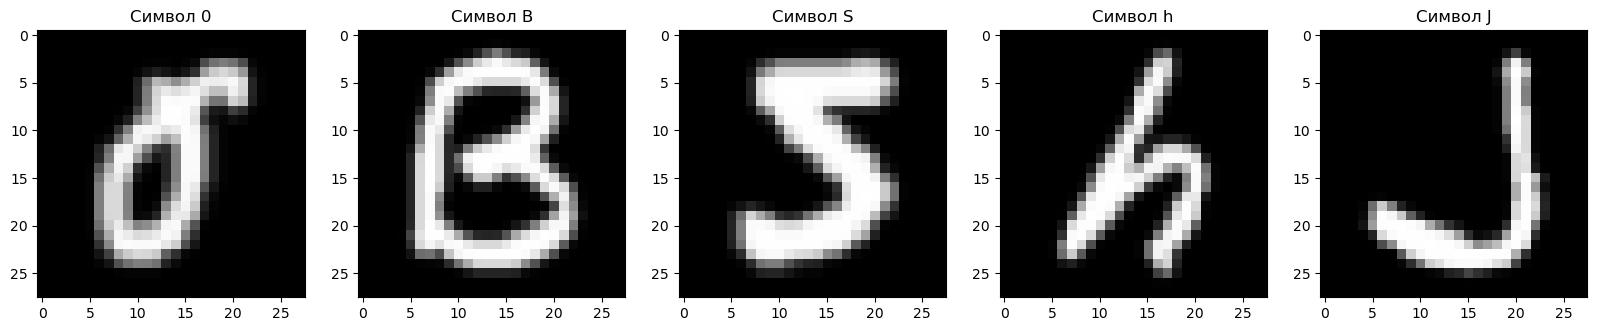

In [5]:
# Выведем 5 случайных изображений и символ, соответствующей лейблу данного изображения
fig, ax = plt.subplots(1, 5, figsize=(20, 12))

rand_numbers = [random.randint(1, 112800) for _ in range(5)]
for i in range(5):
    ax[i].imshow(images_train[rand_numbers[i]], cmap='gray')
    ax[i].set_title(f'Символ {labels_dict[labels_train[rand_numbers[i]]]}')

## **3. Подготовка датасета для обучения и валидации**

In [6]:
X_train = images_train.reshape(-1, 28*28)
y_train = labels_train
X_test = images_test.reshape(-1, 28*28)
y_test = labels_test

print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (112800, 784)
Test: (18800, 784)


## **4. Modeling**

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

### **4.1. Подготовка данных и инициализация нейросети**

In [8]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

train_dataset = MyDataset(X_train, y_train)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset = MyDataset(X_test, y_test)

In [9]:
batch_size = 64

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False
)

In [10]:
class MyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, 128)
        self.layer_2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        x = self.dropout(x)
        out = self.layer_2(x)
        return out

In [11]:
clf = MyNet(784, 47)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(clf.parameters(), lr=0.0001)

### **4.2. Обучение и валидация**

In [12]:
num_epochs = 50
train_loss = [] # Список с функцией потерь на обучении для графика
train_acc = [] # Список метрики accuracy потерь на обучении для графика
val_loss = [] # Список с функцией потерь на валидации для графика
val_acc = [] # Список метрики accuracy потерь на обучении для графика
best_loss = None # Переменная для сохранения лучшего значения функции потерь на валидации
best_model = None # Переменная для сохранения параметров модели при лучшем значении функции потерь на валидации
best_epoch = 0 # Переменная для сохранения номера эпохи при лучшем значении функции потерь на валидации

for epoch in range(num_epochs):
    
    # Обучение модели на тренировочных данных
    clf.train()
    running_train_loss = []
    true_answer = 0
    for X, y in train_dataloader:
        
        # преобразование тензора лейблов в разреженный вид
        y = y.reshape(-1).to(torch.int32)
        y = torch.eye(47)[y]
        
        pred = clf(X)        
        loss = loss_fn(pred, y)           
        opt.zero_grad()
        loss.backward()
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        true_answer += (pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
        
    running_train_acc = true_answer / len(train_dataset)
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # Проверка модели на валидационных данных
    clf.eval()
    with torch.no_grad():
        running_val_loss = []
        true_val_answer = 0

        for X, y in val_dataloader:
            y = y.reshape(-1).to(torch.int32)
            y = torch.eye(47)[y]
            pred = clf(X)        
            loss = loss_fn(pred, y)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            true_val_answer += (pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()

        running_val_acc = true_val_answer / len(val_dataset)
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, train_loss={mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}')

    if best_loss is None:
        best_loss = mean_val_loss

    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        best_model = clf.state_dict()
        best_epoch = epoch+1
print(f'На эпохе {best_epoch} параметры модели были сохранены при наилучшем значении функции потерь {best_loss:.4f} на валидационной выборке')

Epoch 1/50, train_loss=4.6912, train_acc=0.1060, val_loss=2.9531, val_acc=0.2666
Epoch 2/50, train_loss=2.8056, train_acc=0.2835, val_loss=2.0719, val_acc=0.4472
Epoch 3/50, train_loss=2.2229, train_acc=0.4086, val_loss=1.5611, val_acc=0.5754
Epoch 4/50, train_loss=1.8751, train_acc=0.4802, val_loss=1.3327, val_acc=0.6344
Epoch 5/50, train_loss=1.6579, train_acc=0.5307, val_loss=1.1910, val_acc=0.6676
Epoch 6/50, train_loss=1.5162, train_acc=0.5640, val_loss=1.0836, val_acc=0.6949
Epoch 7/50, train_loss=1.4141, train_acc=0.5884, val_loss=1.0343, val_acc=0.7063
Epoch 8/50, train_loss=1.3389, train_acc=0.6090, val_loss=0.9670, val_acc=0.7127
Epoch 9/50, train_loss=1.2698, train_acc=0.6249, val_loss=0.9451, val_acc=0.7246
Epoch 10/50, train_loss=1.2259, train_acc=0.6362, val_loss=0.9074, val_acc=0.7305
Epoch 11/50, train_loss=1.1730, train_acc=0.6478, val_loss=0.8833, val_acc=0.7399
Epoch 12/50, train_loss=1.1313, train_acc=0.6601, val_loss=0.8534, val_acc=0.7497
Epoch 13/50, train_loss=1

Выведем на экран распределение функции потерь.

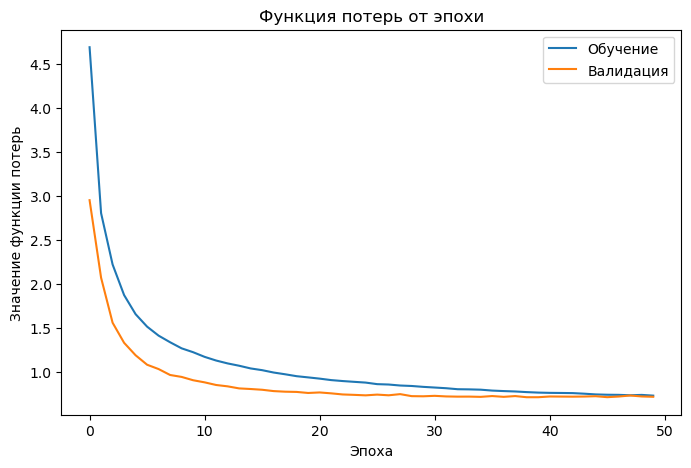

In [13]:
step = np.arange(0, num_epochs)

fig, ax = plt.subplots(figsize=(8,5))

# Зависимость ошибки от эпохи обучения
plt.plot(step, np.array(train_loss))
plt.plot(step, np.array(val_loss))
plt.title('Функция потерь от эпохи')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.legend(['Обучение', 'Валидация'])
plt.show()

Как видим из графика, гиперпараметры модели подобрали хорошо, т.к. графики функии потерь и валидации сходятся к окончанию обучения. Переобучения не допущено. При подборе изменял следующие гиперпараметры модели: увеличивал количество скрытых слоев до двух; увеличивал количество нейронов в слоях (1024, 512, 256); менял размер батча (32, 128); менял параметр функции nn.Dropout (0.2, 0.4, 0.5); скорость обучения.

**Наилучшим образом (скорость обучения, сходимость функций потерь при обучении и валидации, метрика) показали себя следующие гиперпараметры: один скрытый слой с 128 нейронами; размер батча 64; значение функции nn.Dropout(0.3); скорость обучения 0.0001.**

### **4.3. Оценка качества модели на тестовой выборке**

Загрузим наилучшие параметры в нашу модель и оценим метрику Accuracy на тестовой выборке

In [14]:
clf.load_state_dict(best_model) 

<All keys matched successfully>

In [15]:
clf.eval()
with torch.no_grad():    
    running_test_loss = []
    true_test_answer = 0

    for X, y in test_dataloader:
        y = y.reshape(-1).to(torch.int32)
        y = torch.eye(47)[y]
        pred = clf(X)        
        loss = loss_fn(pred, y)

        running_test_loss.append(loss.item())
        mean_test_loss = sum(running_test_loss)/len(running_test_loss)
        true_test_answer += (pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()

    test_acc = true_test_answer / len(test_dataset)
print(f'Метрика accuracy на тестовой выборке {test_acc:.4f}')

Метрика accuracy на тестовой выборке 0.7932


Выведем 5 случайных изображений, распозначание символа и сам символ.

In [16]:
X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32))
clf.eval()
with torch.no_grad():
    predict_test = clf(X_test_tensor)

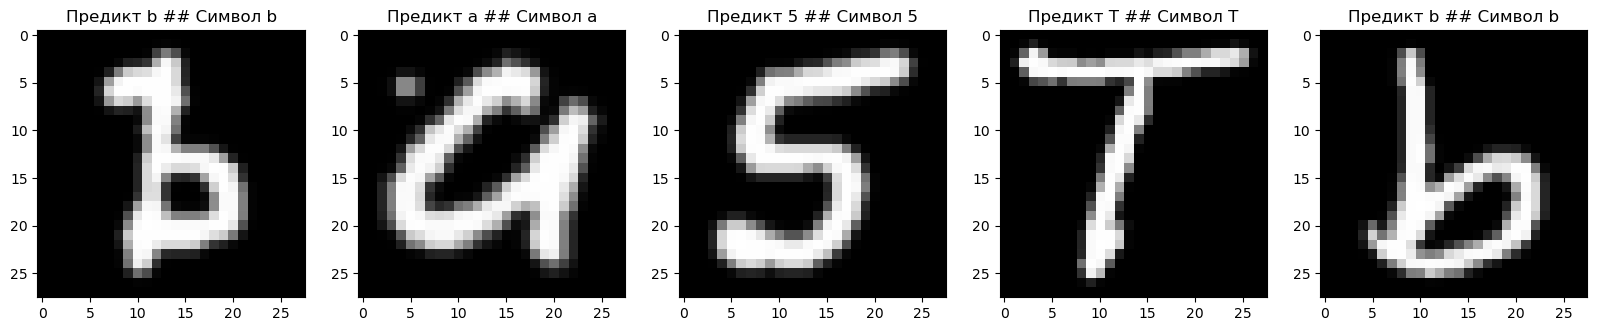

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(20, 12))

rand_numbers = [random.randint(1, len(predict_test)) for _ in range(5)]
for i in range(5):
    ax[i].imshow(images_test[rand_numbers[i]], cmap='gray')
    ax[i].set_title(f'Предикт {labels_dict[predict_test[rand_numbers[i]].argmax().item()]} ## Символ {labels_dict[int(y_test_tensor[rand_numbers[i]].item())]}')

Проанализируем матрицу ошибок для оценки, какие два символа она чаще всего путает и на каком символе модель чаще всего ошибается?

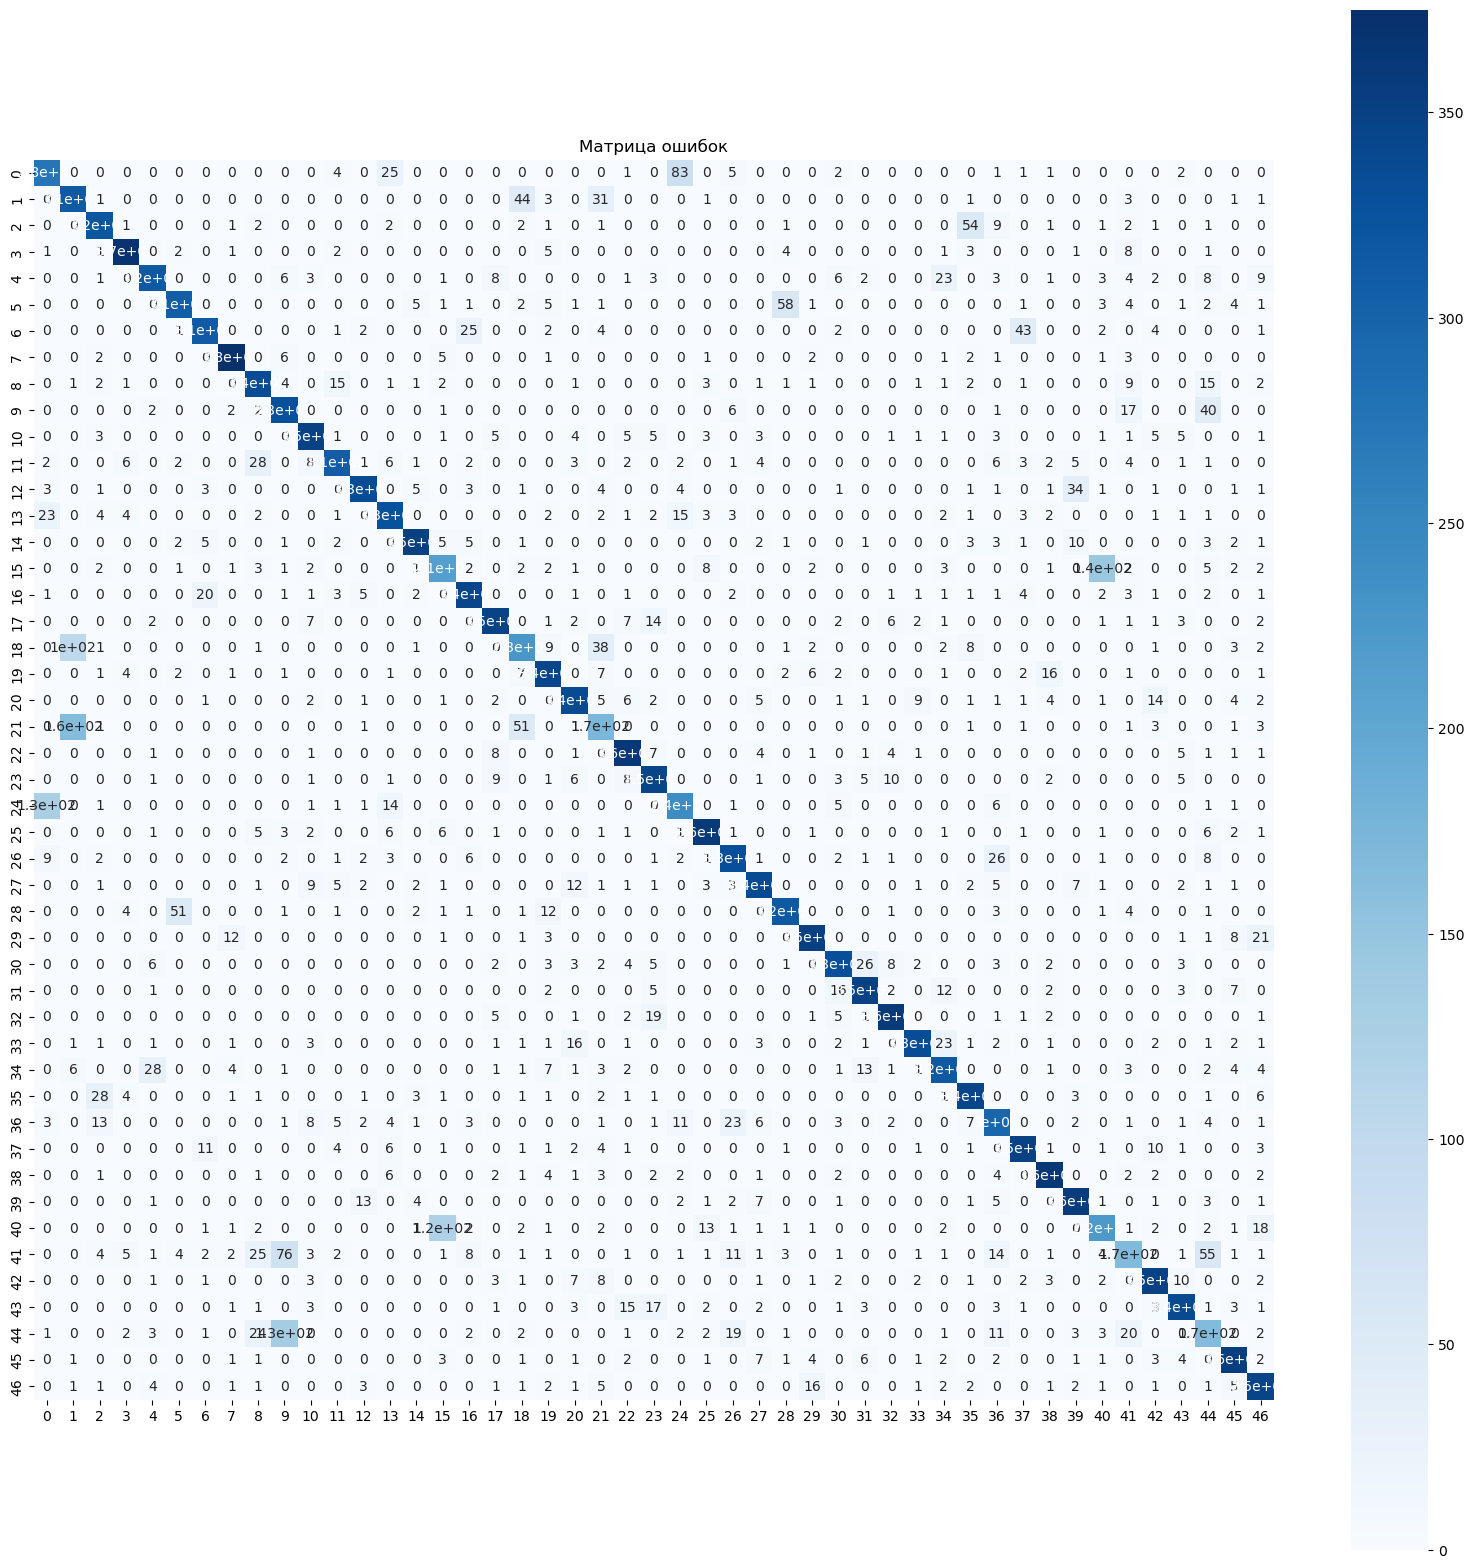

In [18]:
from sklearn.metrics import confusion_matrix
pred_list = [i.argmax().item() for i in predict_test]
label_list = [int(i.item()) for i in y_test_tensor]
cm = confusion_matrix(label_list, pred_list)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, square=True, cmap='Blues')
plt.title('Матрица ошибок')
plt.show()

In [19]:
print(f'Модель чаще всего ошибается на символе {labels_dict[44]}, путая его с цифрой {labels_dict[9]}.')
print(f'Большие ошибки видны на цифре {labels_dict[0]}, которую модель путает с буквой {labels_dict[24]}.')
print(f'Большие ошибки видны на цифре {labels_dict[1]}, которую модель путает с буквой {labels_dict[21]}.')
print(f'Большие ошибки видны на строчной букве {labels_dict[40]}, которую модель путает с заглавной буквой {labels_dict[15]}.')

Модель чаще всего ошибается на символе q, путая его с цифрой 9.
Большие ошибки видны на цифре 0, которую модель путает с буквой O.
Большие ошибки видны на цифре 1, которую модель путает с буквой L.
Большие ошибки видны на строчной букве f, которую модель путает с заглавной буквой F.


### **4.4. Сериализация модели**

In [20]:
# Сохранение модели в формате pkl
with open(os.path.join('myapp', 'model.pkl'),'wb') as f:
    pickle.dump(best_model, f)